# SUMMA Turbulence Scheme Conversion
### fortran to python conversions of SUMMA's turbulence schemes
### -> turbpy python package

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

# turbpy
import turbpy
import turbpy.multiConst as mc

/Users/karllapo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'           # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'    # Processed data directory

### Check behavior of stability functions


In [3]:
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')
sfcTemp = 258.
airTemp = np.arange(253,293)
windspd = 2.
mHeight = 2.
z0Ground = .005
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress,_) = turbpy.satVapPress(airTemp-273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp-273.)
airPressure = 101000.

RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)

## Test Stability Functions

In [4]:
## Calculate stability
stabilitySchemes = {
    ixStability[0]:np.zeros_like(RiBulk),
    ixStability[1]:np.zeros_like(RiBulk),
    ixStability[2]:np.zeros_like(RiBulk),
    ixStability[3]:np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStability[0]:np.zeros_like(RiBulk),
    ixStability[1]:np.zeros_like(RiBulk),
    ixStability[2]:np.zeros_like(RiBulk),
    ixStability[3]:np.zeros_like(RiBulk),
    }
conductanceLatent = {
    ixStability[0]:np.zeros_like(RiBulk),
    ixStability[1]:np.zeros_like(RiBulk),
    ixStability[2]:np.zeros_like(RiBulk),
    ixStability[3]:np.zeros_like(RiBulk),
    }

for stab in stabilitySchemes:
    for n,(tair,vp) in enumerate(zip(airTemp, airVaporPress)):
        (_,stabOutput,_,
         conductanceSensible[stab][n],
         conductanceLatent[stab][n]) = turbpy.aStability(False, stab, mc.stabParams[stab], mHeight, tair,
               vp, sfcTemp, sfcVaporPress, windspd, z0Ground)
        if not 'moninObukhov' in stab:
            stabilitySchemes[stab][n] = stabOutput['stabilityCorrection']

Convergence problem in turbpy.aStability.moninObukhov
Convergence problem in turbpy.aStability.moninObukhov
Convergence problem in turbpy.aStability.moninObukhov
Convergence problem in turbpy.aStability.moninObukhov
Convergence problem in turbpy.aStability.moninObukhov


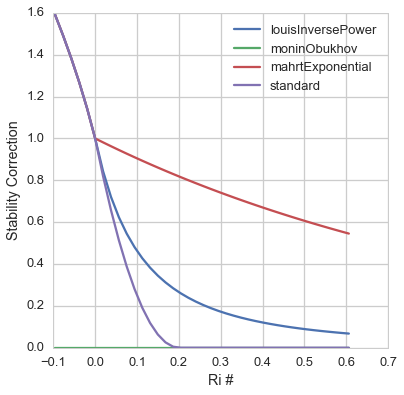

In [5]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for stab in stabilitySchemes:
    ax.plot(RiBulk,stabilitySchemes[stab],label=stab)
ax.legend(loc='best')
ax.set_ylabel('Stability Correction')
ax.set_xlabel('Ri #')

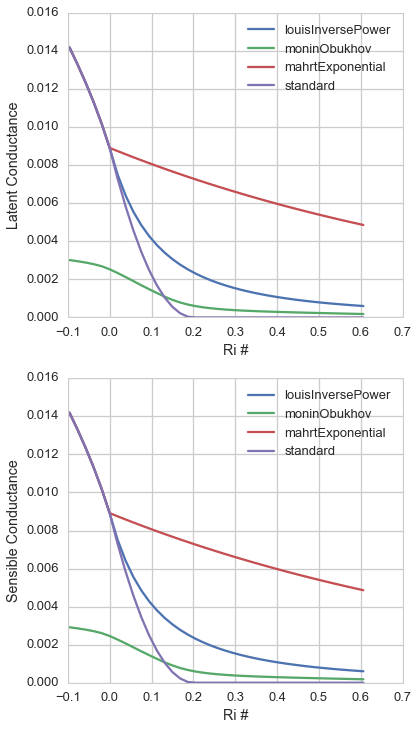

In [6]:
fig,axes = plt.subplots(2,1,figsize=(6,12))

# Latent conductance
ax = axes[0]
for stab in stabilitySchemes:
    ax.plot(RiBulk,conductanceLatent[stab],label=stab)
ax.legend(loc='upper right')
ax.set_ylabel('Latent Conductance')
ax.set_xlabel('Ri #')
# Sensible conductance
ax = axes[1]
for stab in stabilitySchemes:
    ax.plot(RiBulk,conductanceSensible[stab],label=stab)
ax.legend(loc='best')
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')

### Comparing turbpy package to previous functions:
- behavior seems consistent!
- Slightly less control (can't directly prescribe the bulk Richardson number, have to vary it through the air temperatre)

Convergence problem in turbpy.aStability.moninObukhov
Convergence problem in turbpy.aStability.moninObukhov
Convergence problem in turbpy.aStability.moninObukhov
Convergence problem in turbpy.aStability.moninObukhov
Convergence problem in turbpy.aStability.moninObukhov


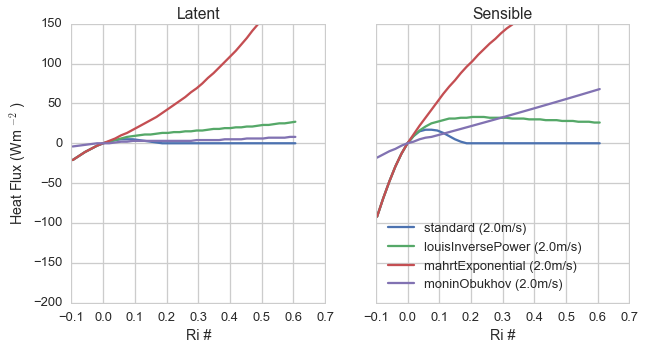

In [7]:
#######
# Plotting arguments
fig,axes = plt.subplots(1,2,sharey=True,figsize=(10,5))

# Plotting parameters
Qmax = 150
Qmin = -50
RiMax = 4
RiMin = -.1

# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)

for sindex,stab in enumerate(ixStability):
    senHeatGround = np.zeros_like(airTemp)
    latHeatGround = np.zeros_like(airTemp)

    for n,(tair,vp) in enumerate(zip(airTemp,airVaporPress)):
        (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
            tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, ixDerivMethod=False, ixStability=stab,
            ixStabParam=mc.stabParams[stab], z0Ground=.005,
            )
        
    ax = axes[0]
    ax.plot(RiBulk, latHeatGround)
    ax.set_ylim(Qmin, Qmax)
    ax.set_xlabel('Ri #')
    ax.set_ylabel('Heat Flux (Wm $^{-2}$ )')
    ax.set_title('Latent')

    ax = axes[1]
    ax.plot(RiBulk, senHeatGround, label=stab + ' (' + str(windspd) + 'm/s)')
    ax.set_ylim(-200, Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title('Sensible')
    ax.legend(loc='best')
# fig.autofmt_xdate()
# fig.savefig('AMTS547.OfflineTurb.Idealized.pdf')